In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [3]:
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path,cols):

    df = load_df(path,cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [4]:
def boxPlotPPMTopBot(dfOG,dfGB,val,var,yaxis,xaxis):

    #get the top/bot 5 for our top/bot ppm
    dfTop5 = dfGB.drop(['average_ppm','std','count'], axis=1).head(5)
    dfBot5 = dfGB.drop(['average_ppm','std','count'], axis=1).tail(5)
    
    #inner join with original values to get the filtered list
    dfJoinTop = pd.merge(dfOG, dfTop5, left_on=var, right_on=var, how='inner')
    dfJoinBot = pd.merge(dfOG, dfBot5, left_on=var, right_on=var, how='inner')
    
    fig, axes = plt.subplots(1,2,constrained_layout=True,figsize=(15,8))

    #plot for top5
    bplotTop=sns.violinplot(y=val, x=var, data=dfJoinTop, width=1, palette="colorblind", cut = 0, ax=axes[0])
    #bplotTop=sns.stripplot(y=val, x=var, data=dfJoinTop, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[0])
    bplotTop.set_xlabel("highest 5 "+xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    
    
    #plot for bot5
    bplotBot=sns.violinplot(y=val, x=var, data=dfJoinBot, width=1, palette="colorblind", cut=0, ax=axes[1])
    #bplotBot=sns.stripplot(y=val, x=var, data=dfJoinBot, jitter=True, marker='o', alpha=0.5, color='black', ax=axes[1])
    bplotBot.set_xlabel("lowest 5 "+xaxis,fontsize=15)
    bplotBot.set_xticklabels(bplotBot.get_xticklabels(),rotation=60)
    bplotBot.set_ylabel(yaxis,fontsize=15)
    bplotBot.tick_params(labelsize=14)
    
    plt.show()
    
def boxPlotPPMAll(df,val,var,yaxis,xaxis):

    plt.figure(figsize=(7,8))
    bplotTop=sns.violinplot(y=val, x=var, data=df, width=1, palette="colorblind", cut=0)
    #bplotTop=sns.stripplot(y=val, x=var, data=df, jitter=True, marker='o', alpha=0.5, color='black')
    bplotTop.set_xlabel(xaxis,fontsize=15)
    bplotTop.set_xticklabels(bplotTop.get_xticklabels(),rotation=60)
    bplotTop.set_ylabel(yaxis,fontsize=15)
    bplotTop.tick_params(labelsize=14)
    
    
    bplotTop.figure

In [5]:
cols1 = ['sample_id', 'network_type', 'mobile_network_type', 'mobile_data_status', 'mobile_data_activity', 'roaming_enabled', 'wifi_status', 'wifi_signal_strength', 'wifi_link_speed', 'wifi_ap_status', 'network_operator', 'sim_operator', 'mcc', 'mnc']
dfNetworkDetails = prepare('2-datasets/network_details.parquet',cols1)

#cols2 = ['id','device_id', 'timestamp', 'battery_level', 'network_status', 'screen_brightness', 'screen_on', 'timezone', 'country_code', 'period', 'size', 'direction', 'ppm']
cols2 = ['id', 'period', 'direction', 'ppm']
dfSamples = prepare('2-datasets/samplesPPM.parquet',cols2)

In [6]:
df_inner = pd.merge(dfSamples, dfNetworkDetails, left_on='id', right_on='sample_id', how='inner')

In [7]:
df_inner_droppedDupGeneral = df_inner.drop(['id','sample_id','wifi_signal_strength','wifi_link_speed','mcc','mnc','wifi_ap_status'], axis=1).drop_duplicates()

In [8]:
df_inner_droppedDupGeneral.head(100)

,period,direction,ppm,network_type,mobile_network_type,mobile_data_status,mobile_data_activity,roaming_enabled,wifi_status,network_operator,sim_operator
0,1,-1.0,0.2026,MOBILE,LTE,CONNECTED,NONE,0,ENABLED,VERIZON,UNKNOWN
11,2,-1.0,0.1869,MOBILE,LTE,CONNECTED,NONE,0,ENABLED,VERIZON,UNKNOWN
15,2,-1.0,0.1869,WIFI,LTE,DISCONNECTED,NONE,0,ENABLED,VERIZON,UNKNOWN
17,2,-1.0,0.1869,MOBILE,LTE,CONNECTED,INOUT,0,ENABLED,VERIZON,UNKNOWN
20,2,-1.0,0.1869,MOBILE,EVDO_A,CONNECTED,NONE,0,ENABLED,VERIZON WIRELESS,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...
698,36,-1.0,0.1869,WIFI,LTE,DISCONNECTED,NONE,0,ENABLED,VERIZON,UNKNOWN
705,37,1.0,0.1090,MOBILE,LTE,CONNECTED,NONE,0,ENABLED,VERIZON,UNKNOWN
706,37,1.0,0.1090,MOBILE,LTE,CONNECTED,OUT,0,ENABLED,VERIZON,UNKNOWN
710,37,1.0,0.1090,MOBILE,LTE,CONNECTED,INOUT,0,ENABLED,VERIZON,UNKNOWN


In [9]:
#due to functional dependicies, individual duplication drops must be done
df_inner_droppedDup_NetworkType = df_inner_droppedDupGeneral.drop(df_inner_droppedDupGeneral.columns.difference(['period', 'direction', 'ppm', 'network_type']), axis=1).drop_duplicates()
df_inner_droppedDup_MobileNetworkType = df_inner_droppedDupGeneral.drop(df_inner_droppedDupGeneral.columns.difference(['period', 'direction', 'ppm', 'mobile_network_type']), axis=1).drop_duplicates()
df_inner_droppedDup_MobileDataStatus = df_inner_droppedDupGeneral.drop(df_inner_droppedDupGeneral.columns.difference(['period', 'direction', 'ppm', 'mobile_data_status']), axis=1).drop_duplicates()
df_inner_droppedDup_MobileDataActivity = df_inner_droppedDupGeneral.drop(df_inner_droppedDupGeneral.columns.difference(['period', 'direction', 'ppm', 'mobile_data_activity']), axis=1).drop_duplicates()
df_inner_droppedDup_Roaming = df_inner_droppedDupGeneral.drop(df_inner_droppedDupGeneral.columns.difference(['period', 'direction', 'ppm', 'roaming_enabled']), axis=1).drop_duplicates()
df_inner_droppedDup_WifiStatus = df_inner_droppedDupGeneral.drop(df_inner_droppedDupGeneral.columns.difference(['period', 'direction', 'ppm', 'wifi_status']), axis=1).drop_duplicates()
df_inner_droppedDup_NetworkOperator = df_inner_droppedDupGeneral.drop(df_inner_droppedDupGeneral.columns.difference(['period', 'direction', 'ppm', 'network_operator']), axis=1).drop_duplicates()
df_inner_droppedDup_SimOperator = df_inner_droppedDupGeneral.drop(df_inner_droppedDupGeneral.columns.difference(['period', 'direction', 'ppm', 'sim_operator']), axis=1).drop_duplicates()

In [10]:
def networkGroupBy(dataframe, var, direction, minCount):
    df = dataframe.groupby([var,'direction'])['ppm'].agg(average_ppm='mean', std='std', count='count').reset_index().sort_values(['average_ppm'], ascending=False)
    return df.loc[(df['direction'] == direction) & (df['count'] >= minCount)]

df_inner_droppedDup_NetworkTypePos = networkGroupBy(df_inner_droppedDup_NetworkType, 'network_type', 1, 0)
df_inner_droppedDup_NetworkTypeNeg = networkGroupBy(df_inner_droppedDup_NetworkType, 'network_type', -1, 0)

df_inner_droppedDup_MobileNetworkTypeGBPos = networkGroupBy(df_inner_droppedDup_MobileNetworkType, 'mobile_network_type', 1, 0)
df_inner_droppedDup_MobileNetworkTypeGBNeg = networkGroupBy(df_inner_droppedDup_MobileNetworkType, 'mobile_network_type', -1, 0)

df_inner_droppedDup_MobileDataStatusGBPos = networkGroupBy(df_inner_droppedDup_MobileDataStatus, 'mobile_data_status', 1, 0)
df_inner_droppedDup_MobileDataStatusGBNeg = networkGroupBy(df_inner_droppedDup_MobileDataStatus, 'mobile_data_status', -1, 0)

df_inner_droppedDup_MobileDataActivityPos = networkGroupBy(df_inner_droppedDup_MobileDataActivity, 'mobile_data_activity', 1, 0)
df_inner_droppedDup_MobileDataActivityNeg = networkGroupBy(df_inner_droppedDup_MobileDataActivity, 'mobile_data_activity', -1, 0)

df_inner_droppedDup_RoamingPos = networkGroupBy(df_inner_droppedDup_Roaming, 'roaming_enabled', 1, 0)
df_inner_droppedDup_RoamingNeg = networkGroupBy(df_inner_droppedDup_Roaming, 'roaming_enabled', -1, 0)

df_inner_droppedDup_WifiStatusPos = networkGroupBy(df_inner_droppedDup_WifiStatus, 'wifi_status', 1, 0)
df_inner_droppedDup_WifiStatusNeg = networkGroupBy(df_inner_droppedDup_WifiStatus, 'wifi_status', -1, 0)

df_inner_droppedDup_NetworkOperatorPos = networkGroupBy(df_inner_droppedDup_NetworkOperator, 'network_operator', 1, 30)
df_inner_droppedDup_NetworkOperatorNeg = networkGroupBy(df_inner_droppedDup_NetworkOperator, 'network_operator', -1, 30)

df_inner_droppedDup_SimOperatorPos = networkGroupBy(df_inner_droppedDup_SimOperator, 'sim_operator', 1, 30)
df_inner_droppedDup_SimOperatorNeg = networkGroupBy(df_inner_droppedDup_SimOperator, 'sim_operator', -1, 30)

          network_type  direction  average_ppm       std   count
1  BLUETOOTH TETHERING        1.0     0.947720  0.614525      60
5              MOBILE2        1.0     0.780309  0.422449      11
9                 WIFI        1.0     0.625681  0.388622  148187
7              UNKNOWN        1.0     0.618700  0.388692  103776
3               MOBILE        1.0     0.614593  0.383932   65973
          network_type  direction  average_ppm       std   count
4              MOBILE2       -1.0     0.615835  0.574610      26
0  BLUETOOTH TETHERING       -1.0     0.337609  0.389164     149
8                 WIFI       -1.0     0.322579  0.383065  184000
2               MOBILE       -1.0     0.316201  0.367030  123895
6              UNKNOWN       -1.0     0.294842  0.369115  135452


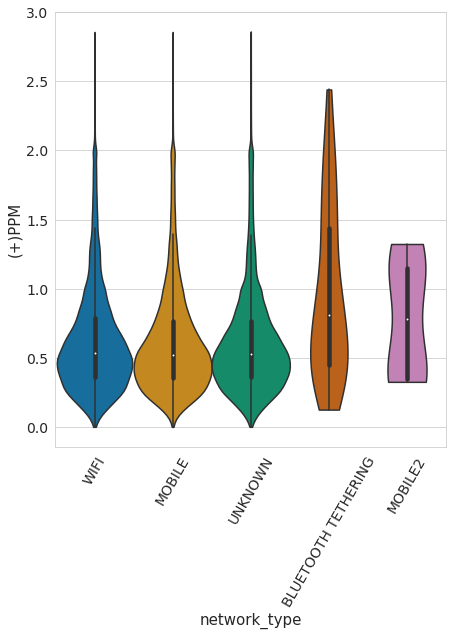

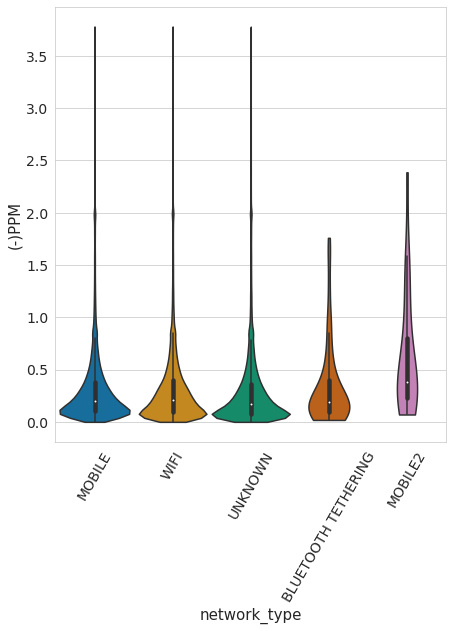

In [20]:
print(df_inner_droppedDup_NetworkTypePos);
boxPlotPPMAll(df_inner_droppedDup_NetworkType.loc[(df_inner_droppedDup_NetworkType['direction'] == 1)],'ppm','network_type','(+)PPM','network_type');
print(df_inner_droppedDup_NetworkTypeNeg);
boxPlotPPMAll(df_inner_droppedDup_NetworkType.loc[(df_inner_droppedDup_NetworkType['direction'] == -1)],'ppm','network_type','(-)PPM','network_type');

   mobile_network_type  direction  average_ppm       std   count
4                   16        1.0     0.702915  0.453351      34
38                UTMS        1.0     0.651645  0.382955   35197
32               HSPAP        1.0     0.650029  0.430572   25484
8                   18        1.0     0.643656  0.353422    2463
30                HSPA        1.0     0.639382  0.419416   48629
28               HSDPA        1.0     0.636870  0.352985    5971
20                EDGE        1.0     0.634652  0.398896   20623
36                 LTE        1.0     0.624988  0.363175  113807
24              EVDO_A        1.0     0.602146  0.312966    1161
1                    0        1.0     0.601767  0.405175   63725
34               HSUPA        1.0     0.597048  0.329115    7826
26                GPRS        1.0     0.590618  0.342123    3966
12               1XRTT        1.0     0.504668  0.287683     510
22               EHRPD        1.0     0.491549  0.223240     420
10                  19   

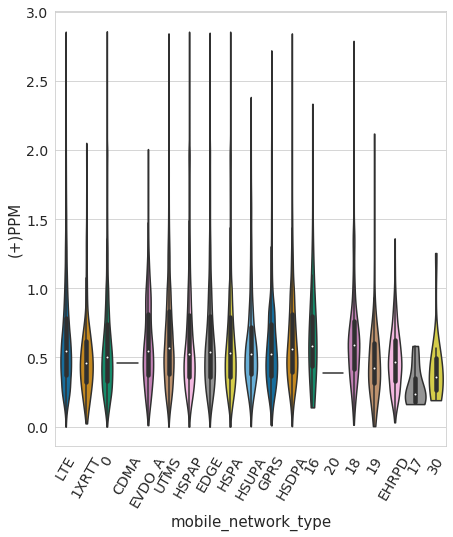

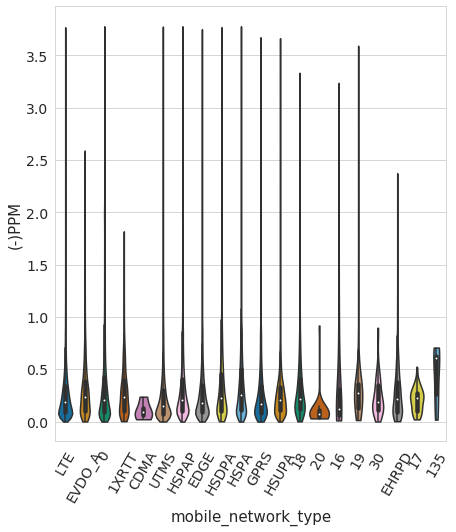

In [21]:
print(df_inner_droppedDup_MobileNetworkTypeGBPos);
boxPlotPPMAll(df_inner_droppedDup_MobileNetworkType.loc[(df_inner_droppedDup_MobileNetworkType['direction'] == 1)],'ppm','mobile_network_type','(+)PPM','mobile_network_type');
print(df_inner_droppedDup_MobileNetworkTypeGBNeg);
boxPlotPPMAll(df_inner_droppedDup_MobileNetworkType.loc[(df_inner_droppedDup_MobileNetworkType['direction'] == -1)],'ppm','mobile_network_type','(-)PPM','mobile_network_type');

  mobile_data_status  direction  average_ppm       std   count
3         CONNECTING        1.0     0.639892  0.384431    2188
5       DISCONNECTED        1.0     0.629698  0.390700  227022
1          CONNECTED        1.0     0.615422  0.382737   67865
7          SUSPENDED        1.0     0.533579  0.311683     780
  mobile_data_status  direction  average_ppm       std   count
4       DISCONNECTED       -1.0     0.330575  0.393199  237650
2         CONNECTING       -1.0     0.328531  0.395748    7023
0          CONNECTED       -1.0     0.317148  0.367489  125063
6          SUSPENDED       -1.0     0.217032  0.204787    3630


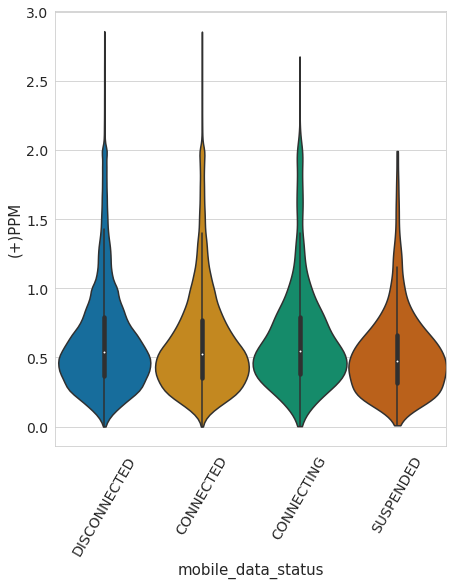

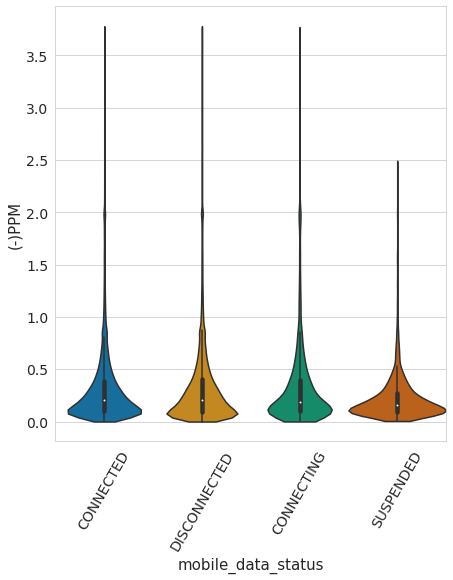

In [22]:
print(df_inner_droppedDup_MobileDataStatusGBPos);
boxPlotPPMAll(df_inner_droppedDup_MobileDataStatus.loc[(df_inner_droppedDup_MobileDataStatus['direction'] == 1)],'ppm','mobile_data_status','(+)PPM','mobile_data_status');
print(df_inner_droppedDup_MobileDataStatusGBNeg);
boxPlotPPMAll(df_inner_droppedDup_MobileDataStatus.loc[(df_inner_droppedDup_MobileDataStatus['direction'] == -1)],'ppm','mobile_data_status','(-)PPM','mobile_data_status');

  mobile_data_activity  direction  average_ppm       std   count
1                   IN        1.0     0.664441  0.404223    4654
3                INOUT        1.0     0.645459  0.400615   61168
7                  OUT        1.0     0.632638  0.410462   26647
5                 NONE        1.0     0.618786  0.382927  241788
  mobile_data_activity  direction  average_ppm       std   count
6                  OUT       -1.0     0.358612  0.400861   68191
4                 NONE       -1.0     0.340593  0.396403  261841
0                   IN       -1.0     0.340111  0.370160   16490
2                INOUT       -1.0     0.327108  0.374131  116595


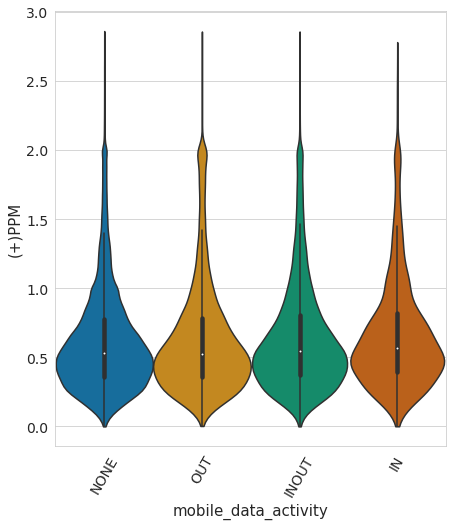

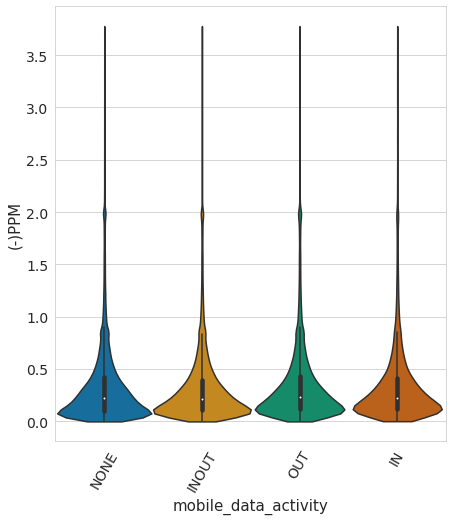

In [23]:
print(df_inner_droppedDup_MobileDataActivityPos);
boxPlotPPMAll(df_inner_droppedDup_MobileDataActivity.loc[(df_inner_droppedDup_MobileDataActivity['direction'] == 1)],'ppm','mobile_data_activity','(+)PPM','mobile_data_activity');
print(df_inner_droppedDup_MobileDataActivityNeg);
boxPlotPPMAll(df_inner_droppedDup_MobileDataActivity.loc[(df_inner_droppedDup_MobileDataActivity['direction'] == -1)],'ppm','mobile_data_activity','(-)PPM','mobile_data_activity');

   roaming_enabled  direction  average_ppm       std   count
3                1        1.0     0.665239  0.393376    5545
1                0        1.0     0.629805  0.391288  268917
   roaming_enabled  direction  average_ppm       std   count
2                1       -1.0     0.352183  0.494213    6384
0                0       -1.0     0.345715  0.401697  272985


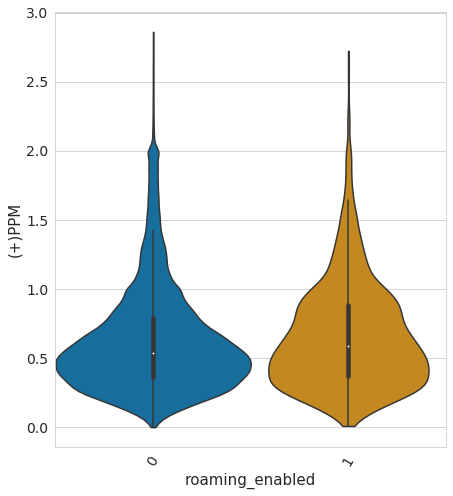

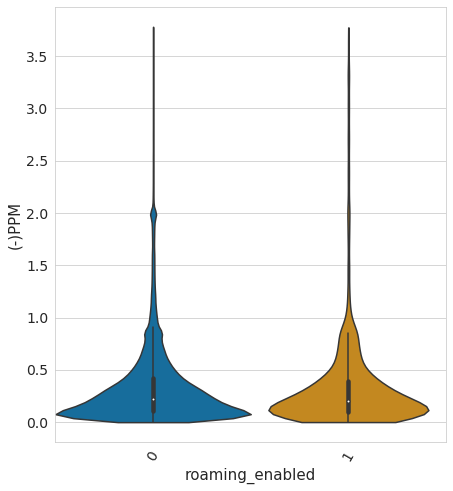

In [24]:
print(df_inner_droppedDup_RoamingPos);
boxPlotPPMAll(df_inner_droppedDup_Roaming.loc[(df_inner_droppedDup_Roaming['direction'] == 1)],'ppm','roaming_enabled','(+)PPM','roaming_enabled');
print(df_inner_droppedDup_RoamingNeg);
boxPlotPPMAll(df_inner_droppedDup_Roaming.loc[(df_inner_droppedDup_Roaming['direction'] == -1)],'ppm','roaming_enabled','(-)PPM','roaming_enabled');

  wifi_status  direction  average_ppm       std   count
9     UNKNOWN        1.0     0.985716  0.610785      64
3   DISABLING        1.0     0.755220  0.488247     128
7    ENABLING        1.0     0.747369  0.481029     193
5     ENABLED        1.0     0.628751  0.392960  181504
1    DISABLED        1.0     0.620408  0.383561  109453
  wifi_status  direction  average_ppm       std   count
8     UNKNOWN       -1.0     0.565858  0.607216      76
6    ENABLING       -1.0     0.392008  0.481184     625
2   DISABLING       -1.0     0.390521  0.503192     458
4     ENABLED       -1.0     0.333153  0.395397  212369
0    DISABLED       -1.0     0.321118  0.377539  127848


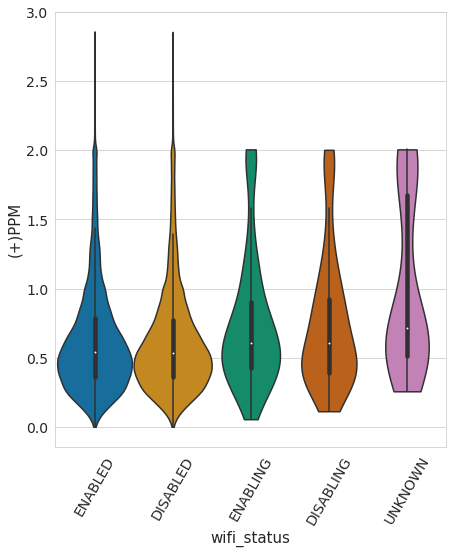

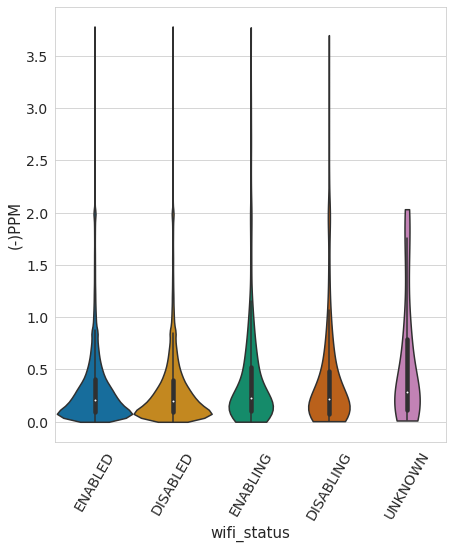

In [25]:
print(df_inner_droppedDup_WifiStatusPos);
boxPlotPPMAll(df_inner_droppedDup_WifiStatus.loc[(df_inner_droppedDup_WifiStatus['direction'] == 1)],'ppm','wifi_status','(+)PPM','wifi_status');
print(df_inner_droppedDup_WifiStatusNeg);
boxPlotPPMAll(df_inner_droppedDup_WifiStatus.loc[(df_inner_droppedDup_WifiStatus['direction'] == -1)],'ppm','wifi_status','(-)PPM','wifi_status');

      network_operator  direction  average_ppm       std  count
1225   MENCARI LAYANAN        1.0     1.291935  0.617465     74
1491               NEO        1.0     1.257471  0.491017     34
2469      TIM 71 | TIM        1.0     1.244778  0.225673     37
2492      TIM 84 | TIM        1.0     1.145862  0.471893     32
2428            TIM 41        1.0     1.145197  0.522016     33
...                ...        ...          ...       ...    ...
203       AIRTEL KENYA        1.0     0.274045  0.131035     33
496            C SPIRE        1.0     0.273881  0.098470     64
2757       VODAFONE GR        1.0     0.266896  0.160025     50
2384  TIGO — TELEMOVIL        1.0     0.257289  0.072483     37
1359           MOVITEL        1.0     0.151410  0.086165     31

[450 rows x 5 columns]


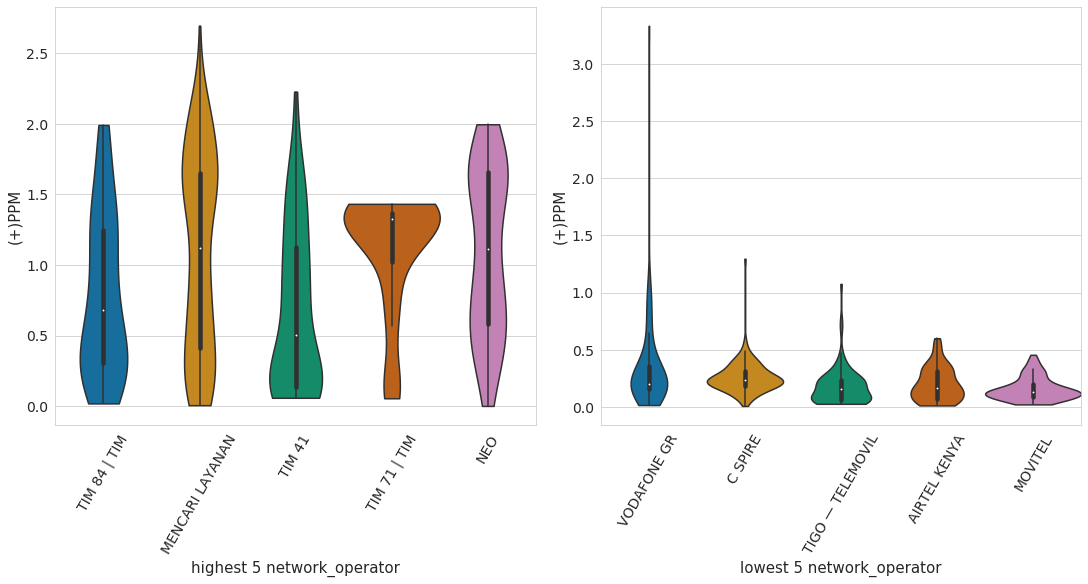

        network_operator  direction  average_ppm       std  count
1178             LUMITEL       -1.0     1.172268  1.025675     40
1501             NET*ONE       -1.0     1.151438  0.191831     40
2994  โทรฉุกเฉินเท่านั้น       -1.0     1.021324  0.803495     34
2606           UA LIFE:)       -1.0     1.013595  0.791595     67
888            GLOBE,TNT       -1.0     0.947211  0.511811     55
...                  ...        ...          ...       ...    ...
2718              VODA P       -1.0     0.085187  0.068956    248
2135          T-MOBILE H       -1.0     0.082046  0.125213    100
1170             LLAMAYA       -1.0     0.081001  0.085548    122
1954   SEM SERVIÇO — TIM       -1.0     0.075081  0.055518     36
2531                TING       -1.0     0.062045  0.091658     49

[497 rows x 5 columns]


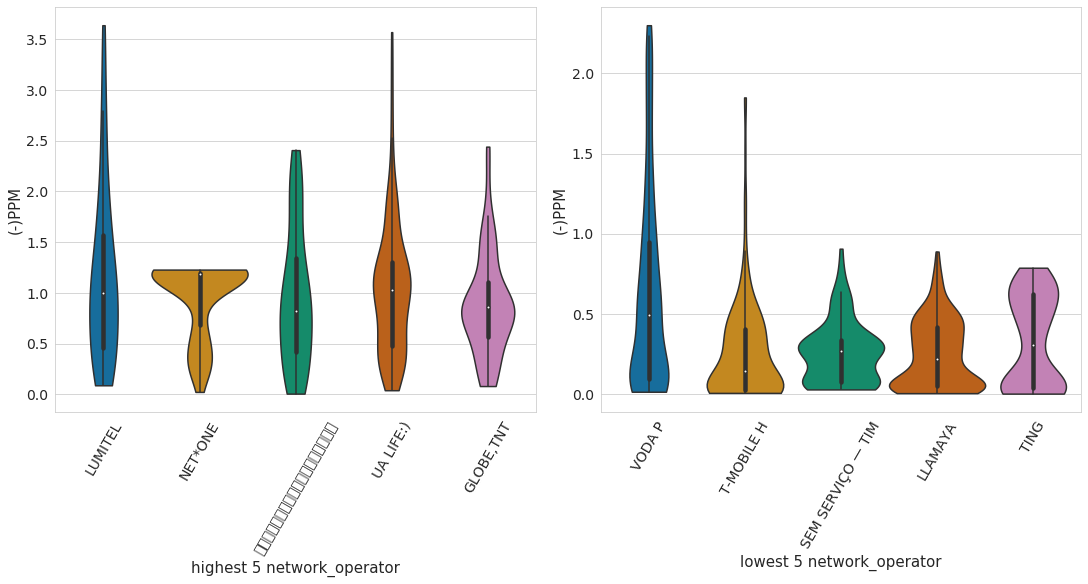

In [27]:
print(df_inner_droppedDup_NetworkOperatorPos);
boxPlotPPMTopBot(df_inner_droppedDup_NetworkOperator,df_inner_droppedDup_NetworkOperatorPos,'ppm','network_operator','(+)PPM','network_operator')
print(df_inner_droppedDup_NetworkOperatorNeg);
boxPlotPPMTopBot(df_inner_droppedDup_NetworkOperator,df_inner_droppedDup_NetworkOperatorNeg,'ppm','network_operator','(-)PPM','network_operator')


                       sim_operator  direction  average_ppm       std  count
699                             MTS        1.0     1.375040  0.607144    126
934                  SEM REDE MÓVEL        1.0     1.295969  0.626595    134
128   APENAS CHAMADAS DE EMERGÊNCIA        1.0     1.230579  0.611958     33
1211                     TIM BRASIL        1.0     1.113980  0.485557    443
435                   GLOBE TELECOM        1.0     1.112325  0.588729    210
...                             ...        ...          ...       ...    ...
454                       HEMAT CSL        1.0     0.275444  0.445860     39
351                          ECONET        1.0     0.269557  0.202462     35
1101                      TELEMOVIL        1.0     0.257289  0.072483     37
1206                   TIM 91 | TIM        1.0     0.256297  0.106751     58
910                       RO ORANGE        1.0     0.178242  0.226724     60

[311 rows x 5 columns]


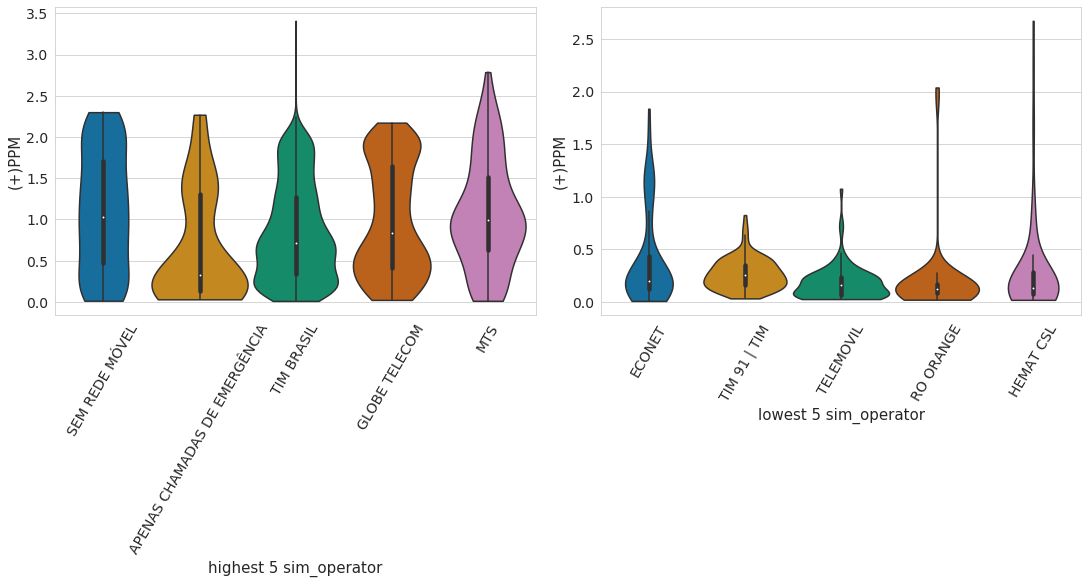

               sim_operator  direction  average_ppm       std  count
1046            TATA DOCOMO       -1.0     1.268273  1.181984    404
1134  TELKOMSEL — TELKOMSEL       -1.0     1.152634  0.590482     70
579                 LUMITEL       -1.0     1.147976  1.024648     41
1321                VIP SRB       -1.0     0.907660  0.638388     42
434           GLOBE TELECOM       -1.0     0.872960  0.722596    218
...                     ...        ...          ...       ...    ...
931     SEM LIGAÇÃO DE REDE       -1.0     0.090186  0.089520     35
571                 LLAMAYA       -1.0     0.081001  0.085548    122
1214        TIMBRASIL — TIM       -1.0     0.076078  0.045523     32
1050     TATA — TATA DOCOMO       -1.0     0.064400  0.057579     44
208             BLUE MOBILE       -1.0     0.023497  0.011896     64

[329 rows x 5 columns]


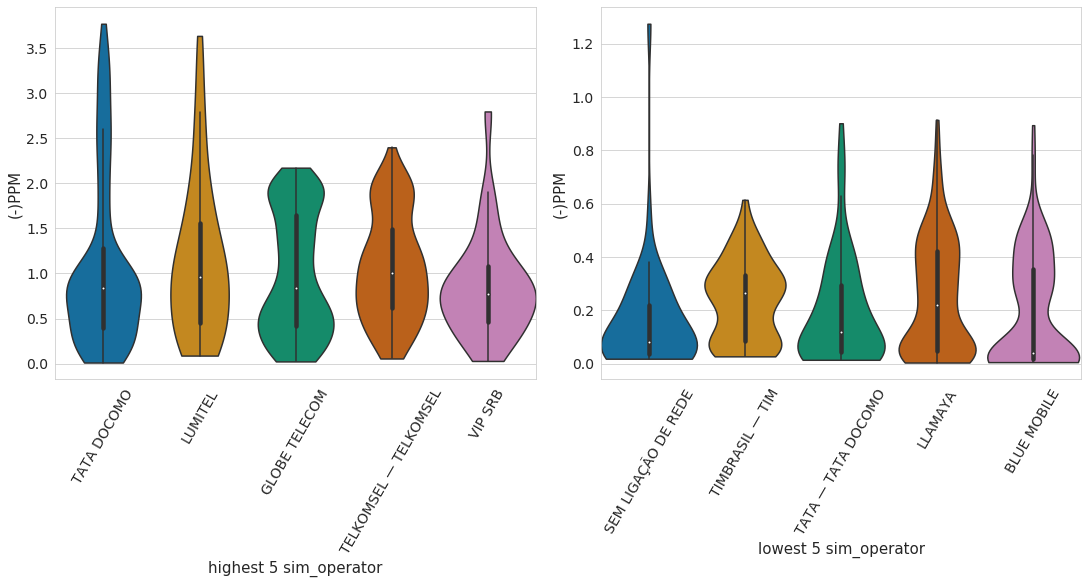

In [30]:
print(df_inner_droppedDup_SimOperatorPos);
boxPlotPPMTopBot(df_inner_droppedDup_SimOperator,df_inner_droppedDup_SimOperatorPos,'ppm','sim_operator','(+)PPM','sim_operator')
print(df_inner_droppedDup_SimOperatorNeg);
boxPlotPPMTopBot(df_inner_droppedDup_SimOperator,df_inner_droppedDup_SimOperatorNeg,'ppm','sim_operator','(-)PPM','sim_operator')

